In [93]:
import os
import random
import gym
import pylab
import numpy as np
from collections import deque
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Lambda, Add, Conv2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import backend as K

def OurModel(input_shape, action_space, dueling):
    X_input = Input(input_shape)
    X = X_input

    # 'Dense' is the basic form of a neural network layer
    # Input Layer of state size(4) and Hidden Layer with 512 nodes
    X = Dense(512//16, input_shape=input_shape, activation="relu", kernel_initializer='he_uniform')(X)

    # Hidden layer with 256 nodes
    X = Dense(256//16, activation="relu", kernel_initializer='he_uniform')(X)
    
    # Hidden layer with 64 nodes
    X = Dense(64//8, activation="relu", kernel_initializer='he_uniform')(X)

    if dueling:
        state_value = Dense(1, kernel_initializer='he_uniform')(X)
        state_value = Lambda(lambda s: K.expand_dims(s[:, 0], -1), output_shape=(action_space,))(state_value)

        action_advantage = Dense(action_space, kernel_initializer='he_uniform')(X)
        action_advantage = Lambda(lambda a: a[:, :] - K.mean(a[:, :], keepdims=True), output_shape=(action_space,))(action_advantage)

        X = Add()([state_value, action_advantage])
    else:
        # Output Layer with # of actions: 2 nodes (left, right)
        X = Dense(action_space, activation="linear", kernel_initializer='he_uniform')(X)

    model = Model(inputs = X_input, outputs = X, name='pesho')
    model.compile(loss="mean_squared_error", optimizer=RMSprop(lr=0.00025, rho=0.95, epsilon=0.01), metrics=["accuracy"])

    model.summary()
    return model

class DQNAgent:
    def __init__(self, env):
        if(env.unwrapped == None):
            self.env_name = env.unwrapped.spec.id
        else:
            self.env_name = "DQNAgent"
            
        self.env = env

        self.env.seed(0)  
        # by default, CartPole-v1 has max episode steps = 500
        self.env._max_episode_steps = 100 # 4000
        self.state_size = self.env.observation_space.shape[0]
        self.action_size = self.env.action_space.n

        self.EPISODES = 1000
        self.memory = deque(maxlen=2000)
        
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01 # minimum exploration probability
        self.epsilon_decay = 0.999 # exponential decay rate for exploration prob
        self.batch_size = 32 
        self.train_start = 1000

        # defining model parameters
        self.ddqn = True # use doudle deep q network
        self.Soft_Update = False # use soft parameter update
        self.dueling = True # use dealing netowrk

        self.TAU = 0.1 # target network soft update hyperparameter

        self.Save_Path = 'Models'
        if not os.path.exists(self.Save_Path): os.makedirs(self.Save_Path)
        self.scores, self.episodes, self.average = [], [], []
        
        if self.ddqn:
            print("----------Double DQN--------")
            self.Model_name = os.path.join(self.Save_Path,"Dueling DDQN_"+self.env_name+".h5")
        else:
            print("-------------DQN------------")
            self.Model_name = os.path.join(self.Save_Path,"Dueling DQN_"+self.env_name+".h5")
        
        # create main model and target model
        self.model = OurModel(input_shape=(self.state_size,), action_space = self.action_size, dueling = self.dueling)
        self.target_model = OurModel(input_shape=(self.state_size,), action_space = self.action_size, dueling = self.dueling)

    # after some time interval update the target model to be same with model
    def update_target_model(self):
        if not self.Soft_Update and self.ddqn:
            self.target_model.set_weights(self.model.get_weights())
            return
        if self.Soft_Update and self.ddqn:
            q_model_theta = self.model.get_weights()
            target_model_theta = self.target_model.get_weights()
            counter = 0
            for q_weight, target_weight in zip(q_model_theta, target_model_theta):
                target_weight = target_weight * (1-self.TAU) + q_weight * self.TAU
                target_model_theta[counter] = target_weight
                counter += 1
            self.target_model.set_weights(target_model_theta)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        if len(self.memory) > self.train_start:
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay

    def act(self, state):
        if np.random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            return np.argmax(self.model.predict(state))

    def replay(self):
        if len(self.memory) < self.train_start:
            return
        # Randomly sample minibatch from the memory
        minibatch = random.sample(self.memory, self.batch_size)

        state = np.zeros((self.batch_size, self.state_size))
        next_state = np.zeros((self.batch_size, self.state_size))
        action, reward, done = [], [], []

        # do this before prediction
        # for speedup, this could be done on the tensor level
        # but easier to understand using a loop
        for i in range(self.batch_size):
            state[i] = minibatch[i][0]
            action.append(minibatch[i][1])
            reward.append(minibatch[i][2])
            next_state[i] = minibatch[i][3]
            done.append(minibatch[i][4])

        # do batch prediction to save speed
        # predict Q-values for starting state using the main network
        target = self.model.predict(state)
        # predict best action in ending state using the main network
        target_next = self.model.predict(next_state)
        # predict Q-values for ending state using the target network
        target_val = self.target_model.predict(next_state)

        for i in range(len(minibatch)):
            # correction on the Q value for the action used
            if done[i]:
                target[i][action[i]] = reward[i]
            else:
                if self.ddqn: # Double - DQN
                    # current Q Network selects the action
                    # a'_max = argmax_a' Q(s', a')
                    a = np.argmax(target_next[i])
                    # target Q Network evaluates the action
                    # Q_max = Q_target(s', a'_max)
                    target[i][action[i]] = reward[i] + self.gamma * (target_val[i][a])   
                else: # Standard - DQN
                    # DQN chooses the max Q value among next actions
                    # selection and evaluation of action is on the target Q Network
                    # Q_max = max_a' Q_target(s', a')
                    target[i][action[i]] = reward[i] + self.gamma * (np.amax(target_next[i]))

        # Train the Neural Network with batches
        self.model.fit(state, target, batch_size=self.batch_size, verbose=0)

    def load(self, name):
        self.model = load_model(name)

    def save(self, name):
        self.model.save(name)

    pylab.figure(figsize=(18, 9))
    def PlotModel(self, score, episode):
        self.scores.append(score)
        self.episodes.append(episode)
        self.average.append(sum(self.scores[-50:]) / len(self.scores[-50:]))
        pylab.plot(self.episodes, self.average, 'r')
        pylab.plot(self.episodes, self.scores, 'b')
        pylab.ylabel('Score', fontsize=18)
        pylab.xlabel('Steps', fontsize=18)
        dqn = 'DQN_'
        softupdate = ''
        dueling = ''
        if self.ddqn: dqn = 'DDQN_'
        if self.Soft_Update: softupdate = '_soft'
        if self.dueling: dueling = '_Dueling'
        try:
            pylab.savefig(dqn+self.env_name+softupdate+dueling+".png")
        except OSError:
            pass

        return str(self.average[-1])[:5]
    
    def run(self):
        for e in range(self.EPISODES):
            state = self.env.reset()
            state = np.reshape(state, [1, self.state_size])
            done = False
            i = 0
            while True:
                #self.env.render()
                action = self.act(state)
                next_state, reward, done, _ = self.env.step(action)
                next_state = np.reshape(next_state, [1, self.state_size])
                if not done or i == self.env._max_episode_steps-1:
                    reward = reward
                else:
                    reward = -100
                self.remember(state, action, reward, next_state, done)
                state = next_state
                i += 1
                # every step update target model
                self.update_target_model()

                # every episode, plot the result
                average = self.PlotModel(i, e)

                if i == self.env._max_episode_steps:
                    #print("Saving trained model as", self.Model_name)
                    #self.save(self.Model_name)
                    break
                self.replay()
            print("episode: {}/{}, e: {:.2}, average: {}".format(e, self.EPISODES, self.epsilon, average))
                
    def test(self):
        self.load(self.Model_name)
        for e in range(self.EPISODES):
            state = self.env.reset()
            state = np.reshape(state, [1, self.state_size])
            done = False
            i = 0
            while not done:
                self.env.render()
                action = np.argmax(self.model.predict(state))
                next_state, reward, done, _ = self.env.step(action)
                state = np.reshape(next_state, [1, self.state_size])
                i += 1
                if done:
                    print("episode: {}/{}, score: {}".format(e, self.EPISODES, i))
                    break

<Figure size 1296x648 with 0 Axes>

----------Double DQN--------
Model: "pesho"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_46 (InputLayer)           [(None, 4)]          0                                            
__________________________________________________________________________________________________
dense_211 (Dense)               (None, 32)           160         input_46[0][0]                   
__________________________________________________________________________________________________
dense_212 (Dense)               (None, 16)           528         dense_211[0][0]                  
__________________________________________________________________________________________________
dense_213 (Dense)               (None, 8)            136         dense_212[0][0]                  
_________________________________________________________________

KeyboardInterrupt: 

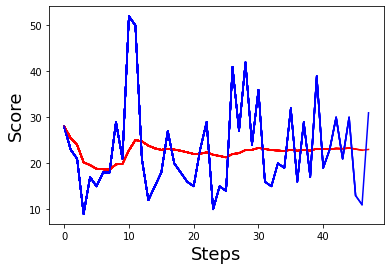

In [81]:
# env_name = 'CartPole-v1'
# env = gym.make(env_name)
env = CartPoleEnv()
agent = DQNAgent(env)
agent.run()
#agent.test()

In [107]:
import socket
import sys

def get_data():
    # Create a TCP/IP socket
    sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)

    # Connect the socket to the port where the server is listening
    server_address = ('127.0.0.1', 34343)
    sock.connect(server_address)

    # Send data
    message = b'GET'
    sock.sendall(message)

    # Look for the response
    amount_received = 0
    amount_expected = len(message)
    total_data = b''
    while amount_received < amount_expected:
        data = sock.recv(16)
        amount_received += len(data)
        total_data += data
    
    lines = total_data.split(b'\n')
    reward = float(lines[0])
    lines = lines[1:]
    data = []
    for line in lines:
        data.append([float(v) for v in line.split(b',')])
    
    lines = total_data.split(b'\n')
    reward = float(lines[0])
    lines = lines[1:]
    data = []
    for line in lines:
        data.append([float(v) for v in line.split(b',')])
#     print(data)
    return (data, reward)

    

In [109]:
get_data()

[[1.0, 2.0], [3.0, 4.0]]


([[1.0, 2.0], [3.0, 4.0]], 1.0)

In [94]:
import math
import gym
from gym import spaces, logger
from gym.utils import seeding
import numpy as np


class TrafficEnv(gym.Env):
    def __init__(self, observation_size=(60, 60, 2), actions_size=9):
        # Limitations

        self.actions = [[0, 0, 0, 0],
                        [5, 0, 0, 0],
                        [0, 5, 0, 0],
                        [0, 0, 5, 0],
                        [0, 0, 0, 5],
                        [-5, 0, 0, 0],
                        [0, -5, 0, 0],
                        [0, 0, -5, 0],
                        [0, 0, 0, -5]]
        
        self.observation_space = spaces.Box(low=-float("inf"), high=float("inf"), shape = (60 * 60 * 2,), dtype=np.float32) # position (1/0) and speed
        print(self.observation_space.shape)
        self.action_space = spaces.Discrete(actions_size)

        self.seed()
        self.state = self.np_random.uniform(low=-0.05, high=0.05, size=(60 * 60 * 2,)) # None

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        err_msg = "%r (%s) invalid" % (action, type(action))
        assert self.action_space.contains(action), err_msg
        # 1. return action changes to sim 'self.actions[action]'
        #    sim exec full cycle
        # 2. get new states + reward
         
        self.state, reward, done = self.np_random.uniform(low=-0.05, high=0.05, size=(60 * 60 * 2,)), 1, True
        
        # call with action to simulation and get the new states and reward

        
        done = False # no unfairable cases
        return np.array(self.state), reward, done, {}

    def reset(self):
        return np.array(self.state)

    def render(self, mode='human'): return

    def close(self): return

(7200,)
----------Double DQN--------
Model: "pesho"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_56 (InputLayer)           [(None, 7200)]       0                                            
__________________________________________________________________________________________________
dense_261 (Dense)               (None, 32)           230432      input_56[0][0]                   
__________________________________________________________________________________________________
dense_262 (Dense)               (None, 16)           528         dense_261[0][0]                  
__________________________________________________________________________________________________
dense_263 (Dense)               (None, 8)            136         dense_262[0][0]                  
_________________________________________________________

KeyboardInterrupt: 

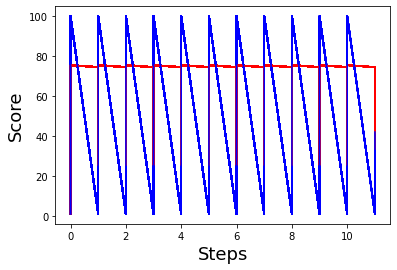

In [95]:
env = TrafficEnv()
agent = DQNAgent(env)
agent.run()
#agent.test()